In [1]:
import cv2
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from scipy.spatial import distance
from skimage import feature, filters, io, morphology, measure, color, draw,transform, util

In [2]:
class Crater():
    def __init__(self, document,tc_y1,tc_y2,tc_x1,tc_x2):
        self.document = document
        self.main_image = io.imread(document,key = 0)
        self.target_crater = self.main_image[tc_y1:tc_y2,tc_x1:tc_x2]
        self.resized_size = 800
        
        
    def get_main_image(self):
        resized_main_image = transform.resize(self.main_image, (self.resized_size , self.resized_size) , anti_aliasing=False)
        return io.imshow(resized_main_image)
    
    def get_crater(self):
        return io.imshow(self.target_crater)
    
    def plot_comparison(self,original, filtered, filter_name):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True, sharey=True)
        ax1.imshow(original, cmap=plt.cm.gray)
        ax1.set_title('original')
        ax1.axis('off')
        ax2.imshow(filtered, cmap=plt.cm.gray)
        ax2.set_title(filter_name)
        ax2.axis('off')
        plt.show()
        
    def __hough_transformation(self,detector,image,diameter_x,diameter_y,num_peaks,fig_name):
        edges = detector
        hough_radii = np.arange(diameter_x,diameter_y, 1)
        hough_res = transform.hough_circle(edges, hough_radii)
        accums, cx, cy, radii = transform.hough_circle_peaks(hough_res, hough_radii,total_num_peaks = num_peaks)

        # Draw
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
        image = color.gray2rgb(image)
        for center_y, center_x, radius in zip(cy, cx, radii):
            circy, circx = draw.circle_perimeter(center_y, center_x, radius, shape=image.shape)
            image[circy, circx] = (255, 0, 0)

        ax.imshow(image, cmap=plt.cm.gray)
        plt.show()
        file_location = "imgs/{}".format(fig_name)
        fig.savefig(file_location)
    
        #Information about data
        print("Center_x > {}, Center_y > {}, radius > {}".format(center_x,center_y,radius))
        radius_o = radius
        x_start = 0 if (center_x - radius) < 0 else center_x - radius
        x_end = center_x + radius
        y_start = 0 if (center_y - radius) < 0 else center_y - radius 
        y_end = center_y + radius
        print("X points: x_start > {}, x_end > {} \nY points: y_start > {}, y_end > {}".format(x_start,x_end,y_start,y_end))
        
        return y_start,y_end,x_start,x_end,center_x,center_y,radius_o
    
    def __get_threshold_status(self,image):
        high_thresh, thresh_im = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        low_thresh = 0.5*high_thresh
        return high_thresh,low_thresh
        
    def __plt_img(self,image,color,title,file_name = None):
        plt.imshow(image,cmap="gray")
        plt.title(title)
        plt.show()
        if file_name != None:
            file = "imgs/{}".format(file_name)
            io.imsave(file,image)
        
        
    
    def program(self):
        #Preprocessing image using erosion and rgb2gray
        selem = morphology.disk(2)
        eroded = morphology.erosion(self.target_crater, selem)
        self.plot_comparison(self.target_crater,eroded,"erosion")
        
        #Plot eroded image and save it
        self.__plt_img(eroded,"gray","erosion","eroded.jpg")
        
        #Get threshold status for our image and compare it with experimental values
        threshold_status = self.__get_threshold_status(eroded)
        low_thresh= threshold_status[1]
        high_tresh = threshold_status[0]
        print("Recomended High threshold -> {}, Low threshold -> {}".format(high_tresh, low_thresh))
        print("Our High threshold -> {}, Low threshold -> {}".format(4, 9))
        
        canny_crater_instructed = feature.canny(eroded, sigma=15,high_threshold = high_tresh,low_threshold = low_thresh)
        canny_crater = feature.canny(eroded, sigma=15,high_threshold = 4,low_threshold=9)
        
        #Plot canny detector image and save it
        self.__plt_img(canny_crater,"magma","Canny detector with experimental values","canny1.jpg")

        #Find big crater in given image 
        big_crater = self.__hough_transformation(canny_crater,self.target_crater,330,350,1,"crater_canny.jpg")
        
        #Crop image according to the marked circle
        cropped_image_circle = self.target_crater[big_crater[0]:big_crater[1],big_crater[2]:big_crater[3]]
        
        self.__plt_img(cropped_image_circle,"gray","Cropped image according to the marked circle - Hough. Transf.","cropped_circle.jpg")
        
        '''Step 2'''
        #Re-preprocessing of our image to get a smaller image later
        selem = morphology.disk(8)
        eroded = morphology.erosion(cropped_image_circle, selem)
        #io.imsave("something.jpg",eroded)
        
        #Use sable detection to prevent multiple circles from being marked
        edge_sobel = filters.sobel(eroded)
        self.__plt_img(edge_sobel,"magma","Sobel edge detection","sobel.jpg")

        big_crater = self.__hough_transformation(edge_sobel,cropped_image_circle,300,350,1,"crater_sobel.jpg")
        final_center = [big_crater[4], big_crater[5], big_crater[6]]
        print("--------\nRadius of our cirlce is {}\n--------".format(final_center[2]))
        second_cropped_image_circle = cropped_image_circle[big_crater[0]:big_crater[1],big_crater[2]:big_crater[3]]
        self.__plt_img(second_cropped_image_circle,"gray","Second cropped image according to the marked circle.","second_cropped_circle.jpg")
        
        #Preprocessing image to get small craters
        selem = morphology.disk(2)
        eroded = morphology.erosion(second_cropped_image_circle, selem)
        io.imsave("imgs/final_eroded.jpg",eroded)
        
        canny_crater = feature.canny(eroded, sigma=3)
        self.__plt_img(canny_crater,"magma","Canny detector to detect small craters","final_canny.jpg")
        
        #last-end
        points_x,points_y,points_radius = [],[],[]
        inside_points_x, inside_points_y, inside_points_radius = [],[],[]
        
        edges = canny_crater
        image = second_cropped_image_circle
        hough_radii = np.arange(5,35, 1)
        hough_res = transform.hough_circle(edges, hough_radii)
        accums, cx, cy, radii = transform.hough_circle_peaks(hough_res, hough_radii,total_num_peaks=20)
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
        image = color.gray2rgb(image)
        red = (255, 0, 0)
        green = (0, 255, 0)
        
        for center_y, center_x, radius in zip(cy, cx, radii):
            a = (final_center[0],final_center[1])
            b = (center_x,center_y)
            euclid_dist = distance.euclidean(a,b)
            print(euclid_dist)
            
            if euclid_dist < final_center[2] + 12:
                circy, circx = draw.circle_perimeter(center_y, center_x, radius,shape=image.shape)
                label_diameter = "{}".format(radius)
                label_coordinates = "[x:{},y:{}]".format(center_x,center_y)
                plt.text(center_x,center_y,label_diameter,fontsize=12,color="yellow")
                #plt.text(center_x+5,center_y,label_coordinates,fontsize=10,color="yellow")
                inside_points_x.append(center_x)
                inside_points_y.append(center_y)
                inside_points_radius.append(radius)
    
                image[circy, circx] = green
                image[circy+1, circx+1] = green
                image[circy+2, circx+2] = green
                image[circy-1, circx-1] = green
                image[circy-2, circx-2] = green
            
            else:
                circy, circx = draw.circle_perimeter(center_y, center_x, radius,
                                    shape=image.shape)
                points_x.append(center_x)
                points_y.append(center_y)
                points_radius.append(radius)
                image[circy, circx] = red
                image[circy+1, circx+1] = red
                image[circy+2, circx+2] = red
                image[circy-1, circx-1] = red
                image[circy-2, circx-2] = red
                
        ax.imshow(image, cmap=plt.cm.gray)
        plt.show()
        io.imsave("imgs/final.jpg",image)
        
        print("Points inside marked circle: {}\nPoints out of marked circle {}".format(len(inside_points_x),len(points_x)))


        
        
        
        
        

In [3]:
crater = Crater("WAC_GL000.tif",21200,21850,21050,21850)

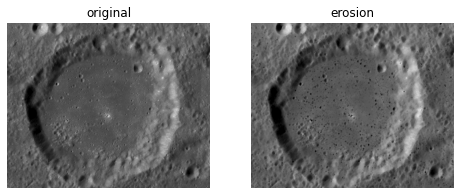

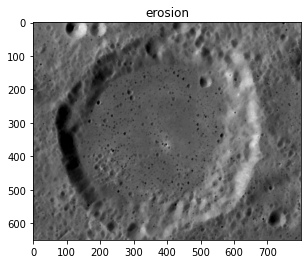

Recomended High threshold -> 87.0, Low threshold -> 43.5
Our High threshold -> 4, Low threshold -> 9


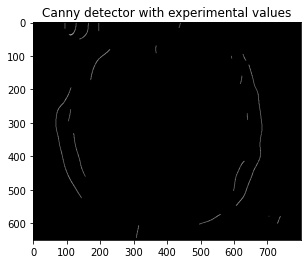

<ipython-input-2-2c2bf7992c20>:66: UserWarning: imgs/canny1.jpg is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(file,image)
<ipython-input-2-2c2bf7992c20>:66: UserWarning: imgs/canny1.jpg is a low contrast image
  io.imsave(file,image)


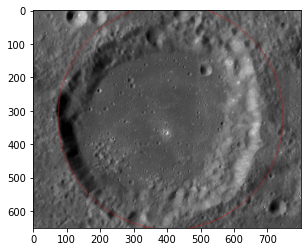

Center_x > 411, Center_y > 318, radius > 336
X points: x_start > 75, x_end > 747 
Y points: y_start > 0, y_end > 654


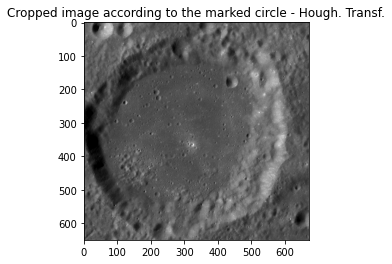

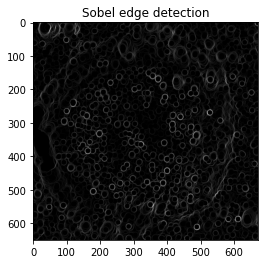

<ipython-input-2-2c2bf7992c20>:66: UserWarning: imgs/sobel.jpg is a low contrast image
  io.imsave(file,image)
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


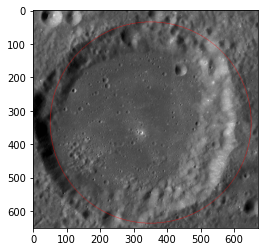

Center_x > 351, Center_y > 335, radius > 300
X points: x_start > 51, x_end > 651 
Y points: y_start > 35, y_end > 635
--------
Radius of our cirlce is 300
--------


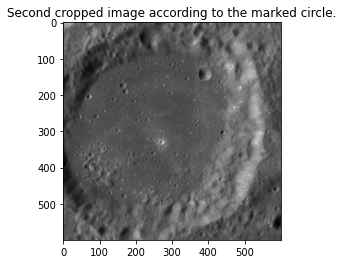

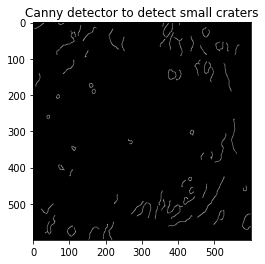

<ipython-input-2-2c2bf7992c20>:66: UserWarning: imgs/final_canny.jpg is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(file,image)


249.8039231077046
91.76055797563569
343.6800837988725
155.6181223379848
127.01574705523721
233.64930986416374
235.53555994796199
200.8233054204616
384.03385267447453
174.77127910500627
281.83683222744327
240.3518254559345
250.56935167733502
324.6166970443757
180.23595645708434
92.69843580125827
390.2947604055171
312.75709424407944
312.3027377401614
366.17072520888394


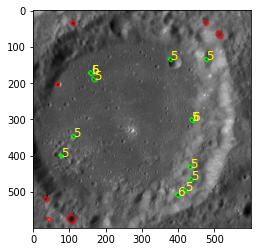

Points inside marked circle: 13
Points out of marked circle 7


In [4]:
crater.program()